In [102]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import impnb
import Data_processing as dp
import ToyQ2
from scipy.optimize import minimize
from functools import partial
from ipywidgets import interact, interactive, fixed, interact_manual

git_data='/cndd/hop006/Github/RewardReversalPorject/Data/epoched_eeg'

behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
Logs=pd.read_pickle(git_data+'/26to38behaviors.pickle')
rat_2_anal=[33, 34, 35, 36, 37, 38, 26, 28, 29, 30, 31]

In [86]:
def myllNEG(action_log,reward_log,params):
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    initQ=[params[3],params[4]]
    
    Q=np.tile(initQ,(n,1))
#     Q=np.zeros((n,2))

    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
        ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
        -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return -np.sum(ll,axis=0)

def myll_log(action_log,reward_log,params):
    n=len(mya)
    alphaG=params[0]
    alphaL=params[1]
    beta=params[2]
    initQ=[params[3],params[4]]
    
    
    Q=np.tile(initQ,(n,1))
#     Q=np.zeros((n,2)) #zero init
#     Q=np.full((n,2),0.5)
    ll=np.zeros((n,1))
    PE=np.zeros((n,1))
    q=np.zeros((n,1))
    for i in range(n):
        choice=int(action_log[i]-1)
        if reward_log[i]:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaG*reward_log[i]
        else:
            Q[i,choice]=(1-alphaG)*Q[i-1,choice]+alphaL*reward_log[i]
            
        Q[i,1-choice]=Q[i-1,1-choice]
        q[i]=Q[i,choice]
        ll[i]=-int(action_log[i]==1)*np.log(1+np.exp(beta*(Q[i,0]-Q[i,1]))) + \
        -int(action_log[i]==2)*np.log(1+np.exp(-beta*(Q[i,0]-Q[i,1])))# test this
        
#         print(i,ll[i],Q[i],action_log[i],reward_log[i])
        PE[i]=Q[i,choice]-reward_log[i]
    return ll,PE,q,Q

def MLE(action_log,reward_log,params0):
    b1=(0.01,0.5)
    b2=(0.5,40)
    b3=(0,1)
    bnds=(b1,b1,b2,b3,b3)
    cur_myll=partial(myllNEG,mya,myr)
    sol=minimize(cur_myll,params0,method='SLSQP',bounds=bnds)
    return sol

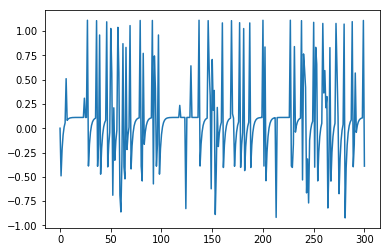

In [90]:
real_params=[0.5,0.5,4,0.1,0.11]
env=ToyQ2.toyQ_2choice()
rat1=dp.Rat(None,*real_params[:-1],init_Q=np.array([0.51,0.51]),sim=True)
env,rat1=dp.train_rat(env,rat1,300,sim=True)
plt.plot(rat1.PElog)
mya=rat1.choice_Log
myr=rat1.obsLog

In [91]:
sol=MLE(mya,myr,real_params)
sol

     fun: 130.61065336882712
     jac: array([ 5.87328116e+03,  0.00000000e+00, -2.72941589e-03, -1.20636189e+02,
        5.28337288e+00])
 message: 'Positive directional derivative for linesearch'
    nfev: 114
     nit: 19
    njev: 15
  status: 8
 success: False
       x: array([1.00000000e-02, 5.00000000e-01, 5.34944481e+00, 9.99999890e-01,
       4.55579808e-05])

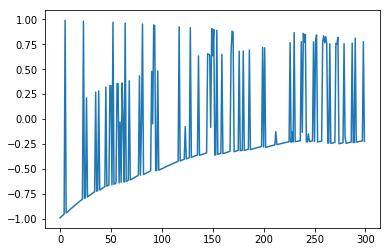

In [92]:
mparams=sol['x']
ll,PE,q,Q=myll_log(mya,myr,mparams)
plt.plot(PE)

# Get all PE logs

In [95]:
real_params=[0.3,0.3,1,0.5,0.5]

33
34
35
36
37
38
26
28
29
30
31


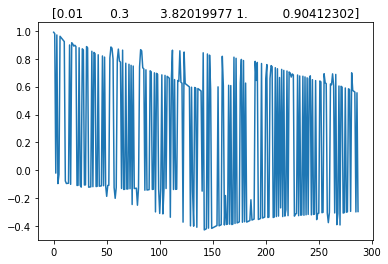

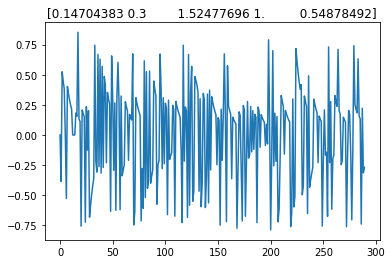

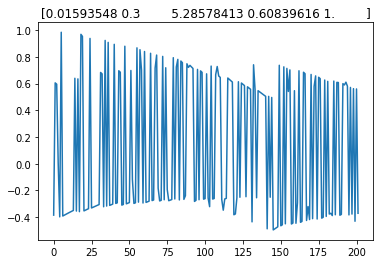

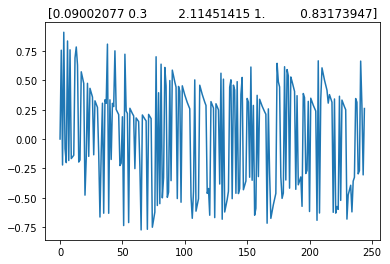

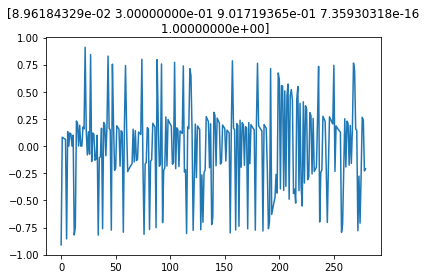

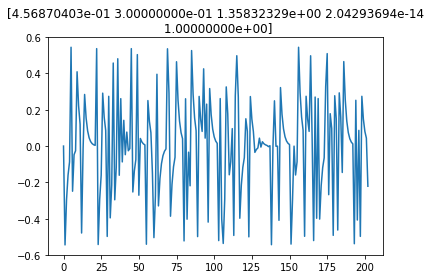

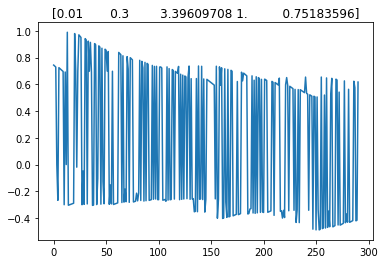

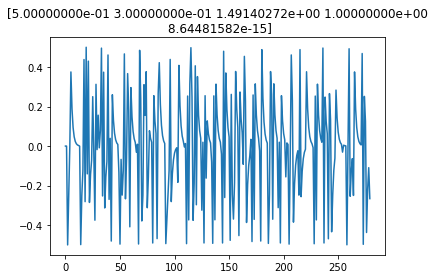

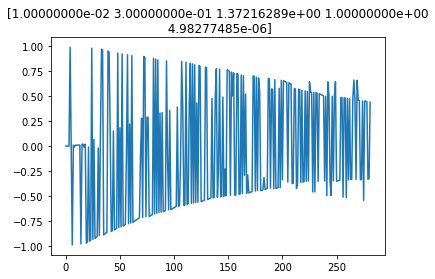

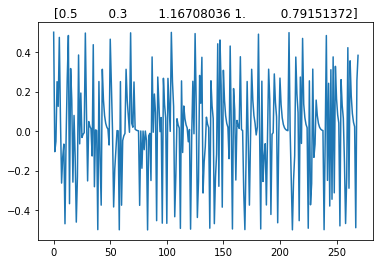

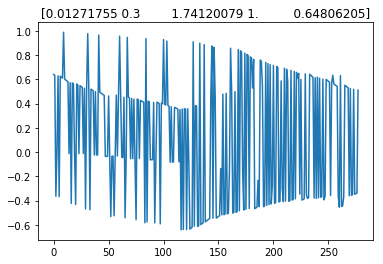

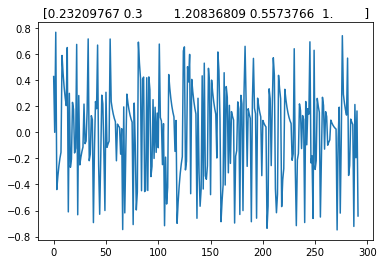

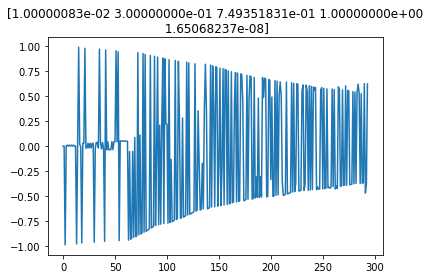

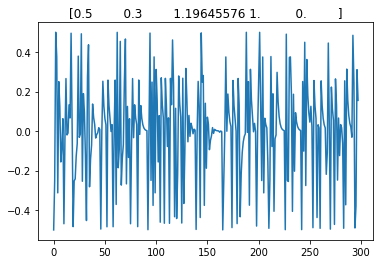

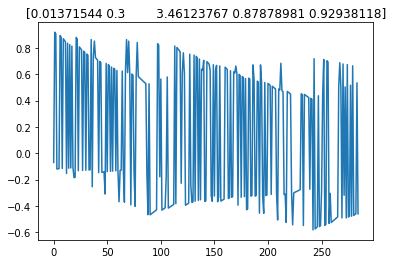

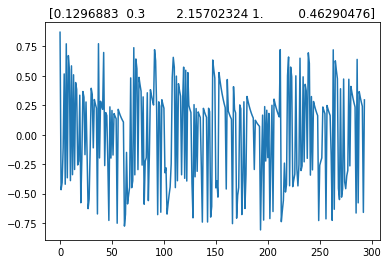

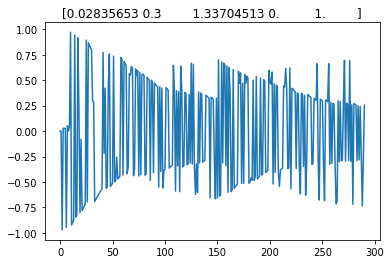

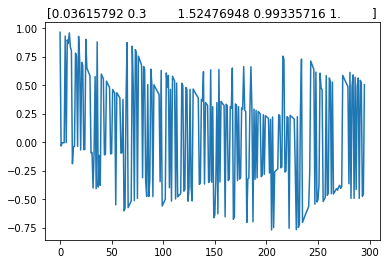

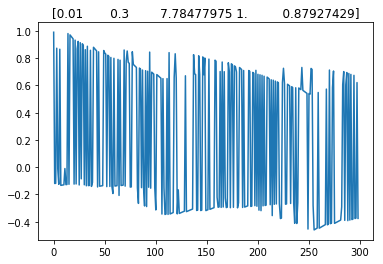

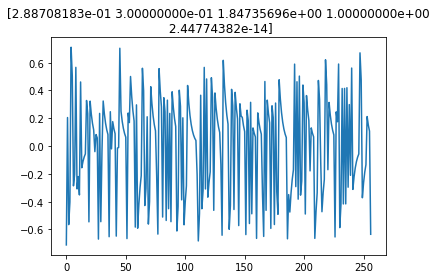

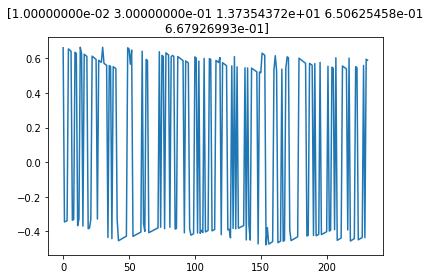

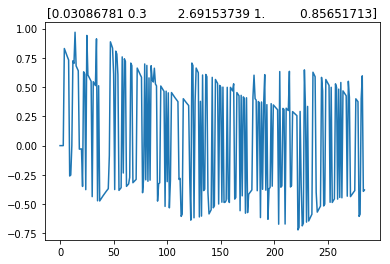

In [96]:
days=2
count=1
PELogs={}
filflag=False

for rat in rat_2_anal:
    print(rat)
    for day in range(days):
        flag='rat_'+str(rat)+'day_'+str(day)
        plt.figure(count)
        count+=1
        
        mya=Logs.loc[flag+'sideaction'][0]
        myr=Logs.loc[flag+'reward'][0]
        
        n=np.min(np.array([mya.size,myr.size]))
        
        mya=mya[:n]
        myr=myr[:n]
        
        sol=MLE(mya[:n],myr[:n],real_params)
        mparams=sol['x']
        ll,PE,q,Q=myll_log(mya[:n],myr[:n],mparams)
        plt.plot(PE)
        plt.title(mparams)
        
        PELogs['rat_'+str(rat)+'day_'+str(day)]=PE
        PELogs['rat_'+str(rat)+'day_'+str(day)+'params']=mparams

In [97]:
PElog_df=pd.Series(PELogs).to_frame('ColumnName')
PElog_df.to_pickle(behavior_log_path+'rat26to38PElog.pkl')

In [101]:
len(rat_2_anal)

11